## Translating Wikidata queries to DBpedia with LLMs chain of thought (CoT) model DeepSeek

In [3]:
# import libraries
import re
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON
from openai import OpenAI

In [2]:
# Load the dataset from 100_complete_entries.json
with open("../../../data/100_complete_entries_wikidata.json", "r") as file:
    data = json.load(file)

# Create input dataset for the LLM
llm_inputs = []

for entry in data:
    # Extract required fields
    question = entry.get("question", "")
    wikidata_query = entry.get("wikidata_query", "")
    
    # Extract entities and relations (ER2) in dbpedia
    er2 = [
        {
            "dbpedia_id": er["dbpedia_id"],
            "wikidata_ids": er["wikidata_ids"]
        }
        for er in entry.get("mapped_entities_relations", {}).get("entities_relations", [])
        if er["dbpedia_id"]
    ]
    
    if not er2:
        continue

    # Construct the input for the LLM
    llm_input = {
        "context": {
            "natural_language_question": question,
            "sparql_query_kg1": wikidata_query,
            "kg1_name": "Wikidata",
            "kg2_name": "DBpedia",
            "er2": er2,
            "instruction": f""""Given the information above, produce a SPARQL query for KG2. First, explain your reasoning step-by-step, detailing how each part of the query is constructed and why certain entities and properties are used. Then, provide the final, complete SPARQL query enclosed within the tags '<sparql>' and '</sparql>'."""
        }
    }    
    llm_inputs.append(llm_input)

# Save the processed dataset to a new JSON file
with open("CoT_input_wikidata_dbpedia.json", "w") as file:
    json.dump(llm_inputs, file, indent=4)

print(f"Processed dataset saved to 'CoT_input_wikidata_dbpedia.json'.")

Processed dataset saved to 'CoT_input_wikidata_dbpedia.json'.


## Running 100 queries
Using DeepSeek R1 Distill Llama 70B for translating the queries from DBpedia to Wikidata.
**DeepSeek R1 Distill Llama 70B available model at Academic Cloud https://chat-ai.academiccloud.de/chat, with 70 billion parameters**

In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "deepseek-r1-distill-llama-70b"

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("CoT_input_wikidata_dbpedia.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question ID {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("CoT_output_deepseek_wikidata_dbpedia.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for all questions saved to 'CoT_output_deepseek_wikidata_dbpedia.json'.")


Translated SPARQL queries for all questions saved to 'CoT_output_deepseek_wikidata_dbpedia.json'.


## Analysis of the results
Extracting the SPARQL queries from LLM output from **DeepSeek R1 Distill Llama 70B**.

In [4]:
def extract_sparql_queries(llm_output):
    """
    Extracts the final SPARQL query from the LLM output.
    Handles cases where queries are enclosed within <sparql>...</sparql> tags or ```sparql``` blocks.
    Removes inline comments marked with # before any other processing.
    """
    # First, remove inline comments marked with #
    llm_output = re.sub(r"# .*?(\n|$)", "\n", llm_output)
    
    # Regex pattern to capture content between <sparql> and </sparql>
    pattern_sparql_tags = r"<sparql>(.*?)</sparql>"
    matches_sparql_tags = re.findall(pattern_sparql_tags, llm_output, re.DOTALL)
    
    if matches_sparql_tags:
        query = " ".join(matches_sparql_tags[-1].replace("\n", " ").split())
    else:
        # Regex pattern to capture content between ```sparql``` blocks
        pattern_code_block = r"```sparql(.*?)```"
        matches_code_block = re.findall(pattern_code_block, llm_output, re.DOTALL)
        
        if matches_code_block:
            query = " ".join(matches_code_block[-1].replace("\n", " ").split())
        else:
            # Alternative extraction for inline SPARQL queries
            pattern_inline = r"(PREFIX .*?SELECT .*? WHERE \{.*?\})"
            matches_inline = re.findall(pattern_inline, llm_output, re.DOTALL)
            
            query = " ".join(matches_inline[-1].replace("\n", " ").split()) if matches_inline else ""
    
    # Remove trailing </sparql> tags if still present
    query = re.sub(r"</sparql>$", "", query).strip()
    
    return query

def process_input_file(input_file, output_file):
    """
    Reads the input JSON file, processes the data, extracts SPARQL queries,
    removes inline comments, and writes the cleaned data to an output JSON file.
    Also calculates statistics on the extraction process.
    """
    with open(input_file, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    cleaned_data = []
    failed_queries = []
    total_entries = len(data)
    extracted_count = 0
    
    for entry in data:
        context = entry.get("context", {})
        natural_language_question = context.get("natural_language_question", "")
        
        # Extract and clean the final SPARQL query
        llm_output = entry.get("sparql_query_kg2", "")
        final_sparql_query = extract_sparql_queries(llm_output)
        
        if natural_language_question and final_sparql_query:
            cleaned_entry = {
                "natural_language_question": natural_language_question,
                "sparql_query_kg2": final_sparql_query
            }
            cleaned_data.append(cleaned_entry)
            extracted_count += 1
        else:
            failed_queries.append({
                "natural_language_question": natural_language_question,
                "sparql_query_raw": llm_output
            })
    
    # Save the successfully extracted queries to a new JSON file
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(cleaned_data, f, indent=2)
    
    # Print statistics
    failed_count = total_entries - extracted_count
    success_rate = (extracted_count / total_entries) * 100 if total_entries > 0 else 0
    
    print(f"Processed {total_entries} entries and saved to {output_file}.")
    print(f"Successfully extracted queries: {extracted_count}")
    print(f"Failed queries: {failed_count}")
    print(f"Extraction success rate: {success_rate:.2f}%")
    
    
if __name__ == "__main__":
    input_filename = "CoT_output_deepseek_wikidata_dbpedia.json"
    output_filename = "CoT_deepseek_wikidata_dbpedia_extracted.json"
    process_input_file(input_filename, output_filename)


Processed 100 entries and saved to CoT_deepseek_wikidata_dbpedia_extracted.json.
Successfully extracted queries: 100
Failed queries: 0
Extraction success rate: 100.00%


## Run the extracted SPARQL queries on DBpedia 
Results for **Deep Seek R1**.

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Token \\".\\": extraneous input \'.\' expecting {\'(\', \'[\', \'true\', \'false\', IRI_REF, PNAME_NS, PNAME_LN, BLANK_NODE_LABEL, VAR1, VAR2, PREFIX_LANGTAG, INTEGER, DECIMAL, DOUBLE, INTEGER_POSITIVE, DECIMAL_POSITIVE, DOUBLE_POSITIVE, INTEGER_NEGATIVE, DECIMAL_NEGATIVE, DOUBLE_NEGATIVE, STRING_LITERAL1, STRING_LITERAL2, STRING_LITERAL_LONG1, STRING_LITERAL_LONG2, NIL, ANON}",\n    "metadata": {\n        "line": 2,\n        "positionInLine": 155,\n        "query": "PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\\nPREFIX dbo: <http://dbpedia.org/ontology/> PREFIX dbr: <http://dbpedia.org/resource/> SELECT DISTINCT ?mountain ?elevation WHERE { ?mountain dbo:Mountains . ?mountain dbo:locatedInArea dbr:Italy . ?mountain dbo:elevation ?elevation . } ORDER BY DESC(?elevation) LIMIT 1",\n        "startIndex"

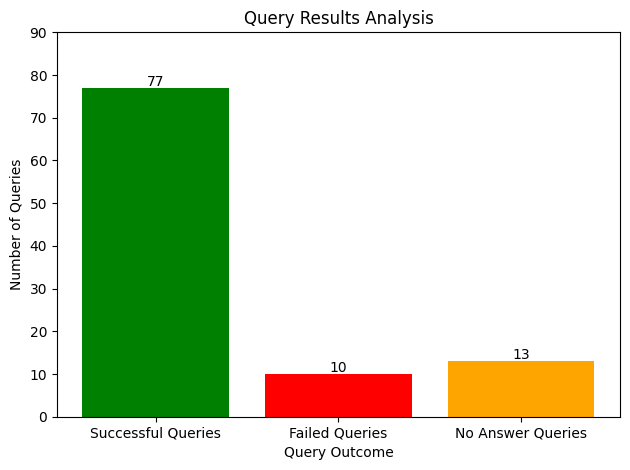

In [4]:
# File paths
input_file_path = "CoT_deepseek_wikidata_dbpedia_extracted.json"
output_file_path = "CoT_deepseek_wikidata_dbpedia_executed.json"

# DBpedia local endpoint
DBpedia_ENDPOINT = "http://localhost:7012"

# Define prefixes for the queries
PREFIXES = """
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX res: <http://dbpedia.org/resource/>
PREFIX yago: <http://dbpedia.org/class/yago/>
PREFIX onto: <http://dbpedia.org/ontology/>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX dbc: <http://dbpedia.org/resource/Category:>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
"""


# Function to check and prepend prefixes if not present
def ensure_prefixes(query):
    required_prefixes = [
        "PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>",
        "PREFIX dbo: <http://dbpedia.org/ontology/>",
        "PREFIX dbr: <http://dbpedia.org/resource/>",
    ]
    
    missing_prefixes = [p for p in required_prefixes if p not in query]
    
    # Ensure the missing prefixes are added to the top
    if missing_prefixes:
        query = "\n".join(missing_prefixes) + "\n" + query
    
    return query



# Function to query the SPARQL endpoint
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)
    
    try:
        return sparql.query().convert()
    except Exception as e:
        print(f"Query failed: {e}")
        return None

# Extract the answers from the SPARQL query results
def extract_answer(results):
    if not results:
        return ["Query failed"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)
    return answers if answers else ["No answer"]

# Load the input dataset
with open(input_file_path, "r") as file:
    data = json.load(file)

# Initialize results list
query_results = []

# Process each query in the dataset
for entry in data:
    question = entry.get("natural_language_question", "")
    sparql_query = entry.get("sparql_query_kg2", "")
    
    if not sparql_query:
        print(f"No SPARQL query found for question: {question}")
        continue

    # Ensure prefixes are included in the query
    sparql_query_with_prefixes = ensure_prefixes(sparql_query)

    # Execute the query on the DBpedia endpoint
    results = query_sparql(DBpedia_ENDPOINT, sparql_query_with_prefixes)
    extracted_answers = extract_answer(results)
    
    # Append the query results
    query_results.append({
        "natural_language_question": question,
        "sparql_query": sparql_query_with_prefixes,
        "answers": extracted_answers
    })

# Save the results to a JSON file
with open(output_file_path, "w") as output_file:
    json.dump(query_results, output_file, indent=4)

print(f"Query results saved to {output_file_path}.")

# Calculate accuracy and categorize results
total_queries = len(data)
successful_queries = sum(1 for result in query_results if "No answer" not in result["answers"] and "Query failed" not in result["answers"])
failed_queries = sum(1 for result in query_results if "Query failed" in result["answers"])
no_answer_queries = sum(1 for result in query_results if "No answer" in result["answers"])
accuracy = (successful_queries / total_queries) * 100 if total_queries > 0 else 0

print(f"Total Queries: {total_queries}")
print(f"Successful Queries: {successful_queries}")
print(f"Failed Queries: {failed_queries}")
print(f"No Answer Queries: {no_answer_queries}")
print(f"Accuracy: {accuracy:.2f}%")

# Visualize results with a bar chart
categories = ['Successful Queries', 'Failed Queries', 'No Answer Queries']
counts = [successful_queries, failed_queries, no_answer_queries]
colors = ['green', 'red', 'orange']

plt.bar(categories, counts, color=colors)
plt.title('Query Results Analysis')
plt.ylabel('Number of Queries')
plt.xlabel('Query Outcome')
plt.ylim(0, 90)
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()

## Comparison of DBpedia output with gold label output
In the following the final output of querying DBpedia is compared to the original output of querying QALD9-Plus dataset.

### Comparison Deep Seek with original output

Comparison completed. Results saved to 'CoT_deepseek_wikidata_dbpedia_results_comparison.xlsx'.
Total Queries: 100
Correct Queries: 63
Incorrect Queries (executed but wrong answer): 14
Query Failed to execute: 10
No Answer Queries (executed but empty answer): 13
Accuracy: 63.00%
Execution Success Rate (ESR): 77.00%


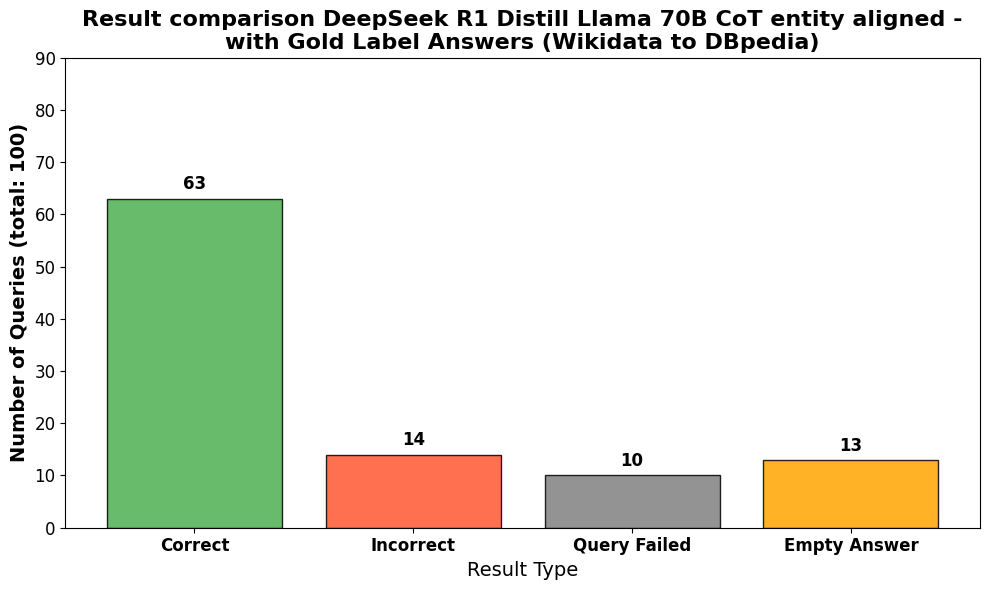

In [5]:
# Define file paths
solution_file_path = "../../../data/100_complete_entries_solution.json"
deepseek_output_file_path = "CoT_deepseek_wikidata_dbpedia_executed.json"

# Load datasets
with open(solution_file_path, 'r') as f:
    solution_data = json.load(f)

with open(deepseek_output_file_path, 'r') as f:
    deepseek_output_data = json.load(f)

# Initialize comparison results and list to hold failed/empty queries
comparison_results = []
failed_or_empty_entries = []

# Create a mapping of questions to their expected results in the solution dataset
solution_mapping = {entry['question']: entry['dbpedia_results'] for entry in solution_data}

# Initialize counters
total_questions = len(deepseek_output_data)
correct_count = 0
incorrect_count = 0
query_failed_count = 0
no_answer_count = 0
successful_executions = 0

# Compare answers and also collect failed queries
for deepseek_entry in deepseek_output_data:
    question = deepseek_entry.get("natural_language_question")
    deepseek_answers = deepseek_entry.get("answers", [])

    # Check for failed queries or empty answers and save them
    if "Query failed" in deepseek_answers:
        query_failed_count += 1
        failed_or_empty_entries.append(deepseek_entry)
        continue
    if "No answer" in deepseek_answers:
        no_answer_count += 1
        failed_or_empty_entries.append(deepseek_entry)
        continue

    expected_answers = solution_mapping.get(question)
    if expected_answers:
        # Check if the expected answers match the LLM output answers (ignoring order)
        is_correct = set(expected_answers) == set(deepseek_answers)
        comparison_results.append({
            "question": question,
            "expected_answers": expected_answers,
            "deepseek_answers": deepseek_answers,
            "is_correct": is_correct
        })
        if is_correct:
            correct_count += 1
        else:
            incorrect_count += 1

    # Count successful query executions (any result other than "Query failed")
    if deepseek_answers and "Query failed" not in deepseek_answers:
        successful_executions += 1

# Save the comparison results to an Excel file for review
output_excel_file = "CoT_deepseek_wikidata_dbpedia_results_comparison.xlsx"
results_df = pd.DataFrame(comparison_results)
results_df.to_excel(output_excel_file, index=False)

# Calculate accuracy and execution success rate (ESR)
accuracy = (correct_count / total_questions) * 100 if total_questions > 0 else 0
execution_success_rate = (successful_executions / total_questions) * 100 if total_questions > 0 else 0

print(f"Comparison completed. Results saved to '{output_excel_file}'.")
print(f"Total Queries: {total_questions}")
print(f"Correct Queries: {correct_count}")
print(f"Incorrect Queries (executed but wrong answer): {incorrect_count}")
print(f"Query Failed to execute: {query_failed_count}")
print(f"No Answer Queries (executed but empty answer): {no_answer_count}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Execution Success Rate (ESR): {execution_success_rate:.2f}%")

# Visualize the results
categories = ['Correct', 'Incorrect', 'Query Failed', 'Empty Answer']
counts = [correct_count, incorrect_count, query_failed_count, no_answer_count]
colors = ['#4CAF50', '#FF5733', '#808080', '#FFA500']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(categories, counts, color=colors, alpha=0.85, edgecolor='black')

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height),
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylabel(f'Number of Queries (total: {total_questions})', fontsize=14, fontweight='bold')

plt.title('Result comparison DeepSeek R1 Distill Llama 70B CoT entity aligned -\nwith Gold Label Answers (Wikidata to DBpedia)', fontsize=16, fontweight='bold')
plt.xlabel('Result Type', fontsize=14)

plt.grid(axis='y', linestyle='', alpha=0.7)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
plt.ylim(0, 90)

plt.tight_layout()
plt.show()

In [1]:
import sys
import os

# Get the absolute path of the current working directory
current_dir = os.getcwd()

# Go two levels up to find the 'sparql_evaluation' folder
parent_dir = os.path.abspath(os.path.join(current_dir, "../../"))

# Set the project root manually as a fallback (adjust if necessary)
manual_project_root = os.path.abspath("Meine Ablage/Master Thesis/SPARQL-Query-Translation-QALD9/QALD9-Plus-testing")

# Ensure both paths are in sys.path
sys.path.append(parent_dir)
sys.path.insert(0, manual_project_root)

# Import the function
try:
    from sparql_evaluation.evaluate_dbpedia import evaluate_dbpedia_queries
    print("Import successful!")
except ModuleNotFoundError as e:
    print("Import failed:", e)

Import successful!


In [2]:
evaluate_dbpedia_queries(
    input_file="CoT_deepseek_wikidata_dbpedia_extracted.json",
    output_excel="CoT_deepseek_dbpedia_results_analysis.xlsx",
    query_key="sparql_query_kg2"
)